**Setup**  
pip install temporian keras pandas tf-nightly scikit-learn -U.

In [16]:
import keras  # To train the Machine Learning model
import temporian as tp  # To convert transactions into tabular data

import numpy as np
import os
import pandas as pd
import datetime
import math
import tensorflow as tf
from sklearn.metrics import RocCurveDisplay

In [15]:
!pip install temporian

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.6/760.6 kB 33.8 MB/s eta 0:00:00


**Loading Dataset**

In [17]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)

# Load the dataset as a Pandas dataframe.
cache_path = "fraud_detection_cache.csv"
if not os.path.exists(cache_path):
    print("Download dataset")
    dataframes = []
    num_files = (end_date - start_date).days
    counter = 0
    while start_date <= end_date:
        if counter % (num_files // 10) == 0:
            print(f"[{100 * (counter+1) // num_files}%]", end="", flush=True)
        print(".", end="", flush=True)
        url = f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/6e67dbd0a3bfe0d7ec33abc4bce5f37cd4ff0d6a/data/{start_date}.pkl"
        dataframes.append(pd.read_pickle(url))
        start_date += datetime.timedelta(days=1)
        counter += 1
    print("done", flush=True)
    transactions_dataframe = pd.concat(dataframes)
    transactions_dataframe.to_csv(cache_path, index=False)
else:
    print("Load dataset from cache")
    transactions_dataframe = pd.read_csv(
        cache_path, dtype={"CUSTOMER_ID": bytes, "TERMINAL_ID": bytes}
    )

print(f"Found {len(transactions_dataframe)} transactions")

Download dataset
[0%]..................[10%]..................[20%]..................[30%]..................[40%]..................[50%]..................[59%]..................[69%]..................[79%]..................[89%]..................[99%]...done
Found 1754155 transactions


In [18]:
transactions_dataframe = transactions_dataframe[
    ["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]
]

transactions_dataframe.head(4)

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,2018-04-01 00:00:31,596,3156,57.16,0
1,2018-04-01 00:02:10,4961,3412,81.51,0
2,2018-04-01 00:07:56,2,1365,146.00,0
3,2018-04-01 00:09:29,4128,8737,64.49,0


In [19]:
fraudulent_rate = transactions_dataframe["TX_FRAUD"].mean()
print("Rate of fraudulent transactions:", fraudulent_rate)

Rate of fraudulent transactions: 0.008369271814634397


**The pandas dataframe is converted into a Temporian EventSet**

In [20]:
transactions_evset = tp.from_pandas(transactions_dataframe, timestamps="TX_DATETIME")

transactions_evset

timestamp,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
2018-04-01 00:00:31+00:00,596,3156,57.16,0
2018-04-01 00:02:10+00:00,4961,3412,81.51,0
2018-04-01 00:07:56+00:00,2,1365,146,0
…,…,…,…,…
2018-09-30 23:58:21+00:00,618,1502,6.62,0
2018-09-30 23:59:52+00:00,4056,3067,55.4,0
2018-09-30 23:59:57+00:00,3542,9849,23.59,0


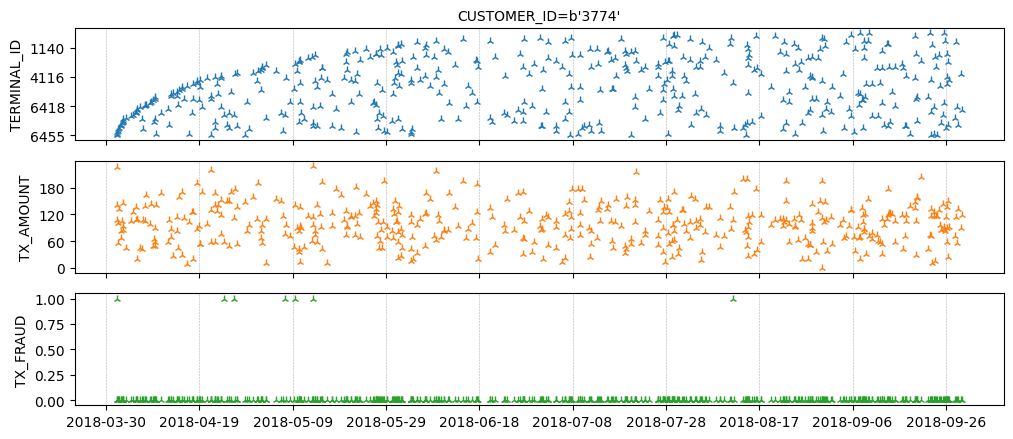

In [21]:
transactions_evset.add_index("CUSTOMER_ID").plot(indexes="3774")

**Preparing the training data**

In [22]:
# Group the transactions per terminal
transactions_per_terminal = transactions_evset.add_index("TERMINAL_ID")

# Moving statistics per terminal
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        transactions_per_terminal["TX_AMOUNT"]
        .moving_sum(tp.duration.days(n))
        .rename(f"sum_transactions_{n}_days")
    )

    tmp_features.append(
        transactions_per_terminal.moving_count(tp.duration.days(n)).rename(
            f"count_transactions_{n}_days"
        )
    )

feature_set_1 = tp.glue(*tmp_features)

feature_set_1

timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-02 01:00:01+00:00,16.07,1,16.07,1,16.07,1
2018-04-02 09:49:55+00:00,83.9,2,83.9,2,83.9,2
2018-04-03 12:14:41+00:00,110.7,3,110.7,3,110.7,3
…,…,…,…,…,…,…
2018-09-29 05:49:27+00:00,871.6,11,1392,19,2345,36
2018-09-29 11:12:46+00:00,910.4,12,1431,20,2383,37
2018-09-30 06:29:54+00:00,799.3,12,1479,21,2418,37
timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-01 16:24:39+00:00,70.36,1,70.36,1,70.36,1
2018-04-02 11:25:03+00:00,87.79,2,87.79,2,87.79,2


**Feature Terminal**

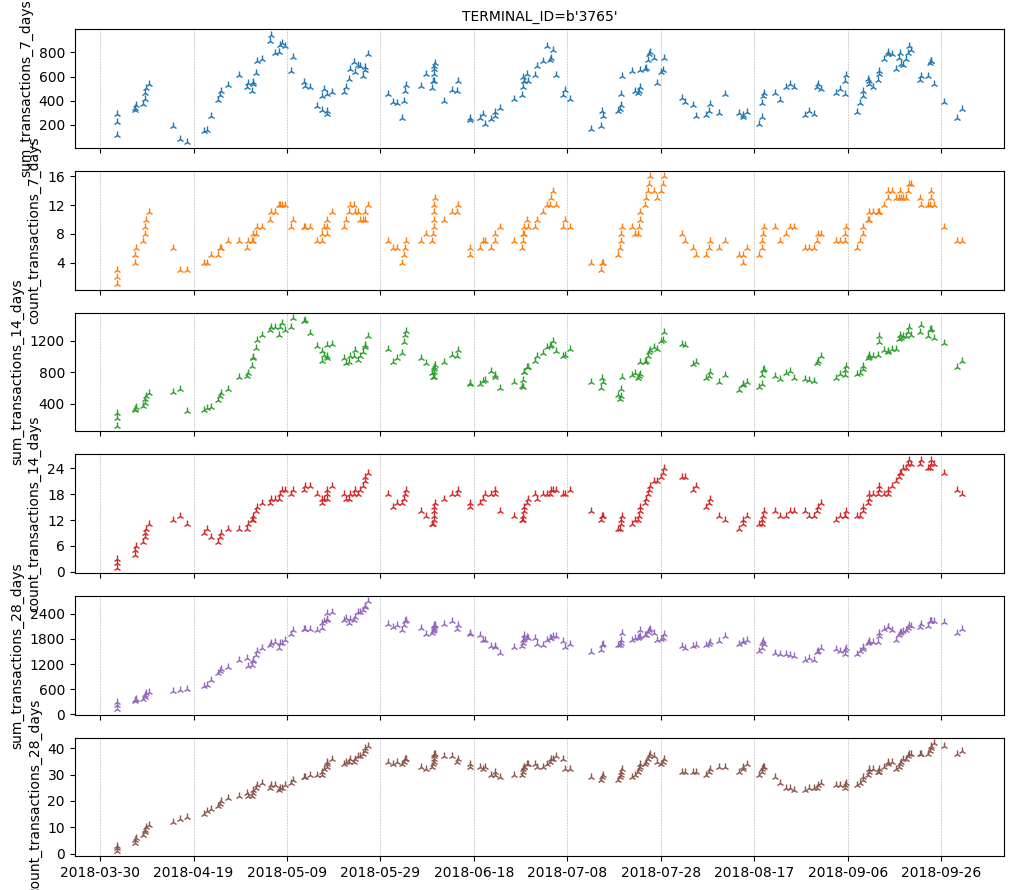

In [24]:
feature_set_1.plot(indexes="3765")

**Evaluation**

In [29]:
# Lag the transactions by one week.
lagged_transactions = transactions_per_terminal.lag(tp.duration.weeks(1))

# Moving statistics per customer
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .moving_sum(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"count_fraud_transactions_{n}_days")
    )

    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .cast(tp.float32)
        .simple_moving_average(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"rate_fraud_transactions_{n}_days")
    )

feature_set_2 = tp.glue(*tmp_features)

In [27]:
feature_set_3 = tp.glue(
    transactions_per_terminal.calendar_hour(),
    transactions_per_terminal.calendar_day_of_week(),
)

In [30]:
all_data = tp.glue(
    transactions_per_terminal, feature_set_1, feature_set_2, feature_set_3
).drop_index()

print("All the available features:")
all_data.schema.feature_names()

All the available features:


['CUSTOMER_ID',
 'TX_AMOUNT',
 'TX_FRAUD',
 'sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week',
 'TERMINAL_ID']

In [31]:
input_feature_names = [k for k in all_data.schema.feature_names() if k.islower()]

print("The model's input features:")
input_feature_names

The model's input features:


['sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week']

In [32]:
# Cast all values (e.g. ints) to floats.
values = all_data[input_feature_names].cast(tp.float32)

# Apply z-normalization overtime.
normalized_features = (
    values - values.simple_moving_average(math.inf)
) / values.moving_standard_deviation(math.inf)

# Restore the original name of the features.
normalized_features = normalized_features.rename(values.schema.feature_names())

print(normalized_features)

indexes: []
features: [('sum_transactions_7_days', float32), ('count_transactions_7_days', float32), ('sum_transactions_14_days', float32), ('count_transactions_14_days', float32), ('sum_transactions_28_days', float32), ('count_transactions_28_days', float32), ('count_fraud_transactions_7_days', float32), ('rate_fraud_transactions_7_days', float32), ('count_fraud_transactions_14_days', float32), ('rate_fraud_transactions_14_days', float32), ('count_fraud_transactions_28_days', float32), ('rate_fraud_transactions_28_days', float32), ('calendar_hour', float32), ('calendar_day_of_week', float32)]
events:
     (1754155 events):
        timestamps: ['2018-04-01T00:00:31' '2018-04-01T00:02:10' '2018-04-01T00:07:56' ...
     '2018-09-30T23:58:21' '2018-09-30T23:59:52' '2018-09-30T23:59:57']
        'sum_transactions_7_days': [ 0.      1.      1.3636 ... -0.064  -0.2059  0.8428]
        'count_transactions_7_days': [   nan    nan    nan ... 1.0128 0.6892 1.66  ]
        'sum_transactions_14_da

/usr/local/lib/python3.10/dist-packages/temporian/implementation/numpy/operators/binary/arithmetic.py:100: RuntimeWarning: invalid value encountered in divide
  return evset_1_feature / evset_2_feature


In [33]:
normalized_features = normalized_features.fillna(0.0)

In [34]:
normalized_all_data = tp.glue(normalized_features, all_data["TX_FRAUD"])

**Split dataset into a train, validation and test set**

In [35]:
# begin_train = datetime.datetime(2018, 4, 8).timestamp() # Full training dataset
begin_train = datetime.datetime(2018, 7, 1).timestamp()  # Reduced training dataset
begin_valid = datetime.datetime(2018, 8, 1).timestamp()
begin_test = datetime.datetime(2018, 9, 1).timestamp()

is_train = (normalized_all_data.timestamps() >= begin_train) & (
    normalized_all_data.timestamps() < begin_valid
)
is_valid = (normalized_all_data.timestamps() >= begin_valid) & (
    normalized_all_data.timestamps() < begin_test
)
is_test = normalized_all_data.timestamps() >= begin_test

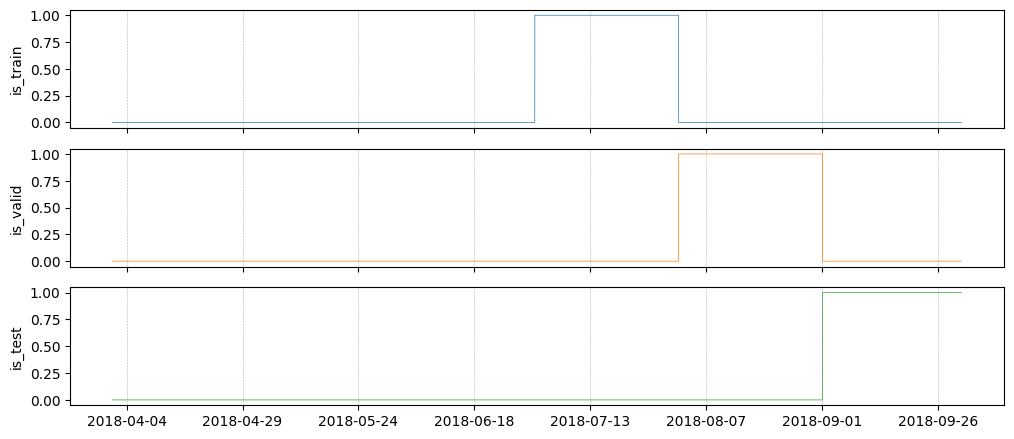

In [36]:
tp.plot(
    [
        is_train.rename("is_train"),
        is_valid.rename("is_valid"),
        is_test.rename("is_test"),
    ]
)

In [37]:
train_ds_evset = normalized_all_data.filter(is_train)
valid_ds_evset = normalized_all_data.filter(is_valid)
test_ds_evset = normalized_all_data.filter(is_test)

print(f"Training examples: {train_ds_evset.num_events()}")
print(f"Validation examples: {valid_ds_evset.num_events()}")
print(f"Testing examples: {test_ds_evset.num_events()}")

Training examples: 296928
Validation examples: 296559
Testing examples: 287873


**Create TensorFlow datasets**

In [38]:
non_batched_train_ds = tp.to_tensorflow_dataset(train_ds_evset)
non_batched_valid_ds = tp.to_tensorflow_dataset(valid_ds_evset)
non_batched_test_ds = tp.to_tensorflow_dataset(test_ds_evset)

In [39]:
def extract_features_and_label(example):
    features = {k: example[k] for k in input_feature_names}
    labels = tf.cast(example["TX_FRAUD"], tf.int32)
    return features, labels


# Target ratio of fraudulent transactions in the training dataset.
target_rate = 0.2

# Number of examples in a mini-batch.
batch_size = 32

train_ds = (
    non_batched_train_ds.shuffle(10000)
    .rejection_resample(
        class_func=lambda x: tf.cast(x["TX_FRAUD"], tf.int32),
        target_dist=[1 - target_rate, target_rate],
        initial_dist=[1 - fraudulent_rate, fraudulent_rate],
    )
    .map(lambda _, x: x)  # Remove the label copy added by "rejection_resample".
    .batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

# The test and validation dataset does not need resampling or shuffling.
valid_ds = (
    non_batched_valid_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    non_batched_test_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [40]:
for features, labels in train_ds.take(1):
    print("features")
    for feature_name, feature_value in features.items():
        print(f"\t{feature_name}: {feature_value[:4]}")
    print(f"labels: {labels[:4]}")

features
	sum_transactions_7_days: [-0.908513   -0.47019276  0.06573577  0.46546963]
	count_transactions_7_days: [-0.23332487 -0.23365611  0.7202681   1.0381902 ]
	sum_transactions_14_days: [-1.5115515 -1.106029   1.8736032  0.9084269]
	count_transactions_14_days: [-1.0962207 -1.0970178  2.0425577  0.380691 ]
	sum_transactions_28_days: [-0.9325886  -0.01749615  3.2529304   1.689501  ]
	count_transactions_28_days: [-0.63424     0.12024121  2.4817033   1.0651494 ]
	count_fraud_transactions_7_days: [-0.09772699 -0.09774984 -0.09772461 -0.09772591]
	rate_fraud_transactions_7_days: [-0.10947144 -0.10945833 -0.1094589  -0.1094605 ]
	count_fraud_transactions_14_days: [-0.1043793  -0.10441419 -0.10437494 -0.10437632]
	rate_fraud_transactions_14_days: [-0.11559689 -0.11558982 -0.11558142 -0.11558311]
	count_fraud_transactions_28_days: [-0.11275478 -0.11279945 -0.11275137 -0.11275212]
	rate_fraud_transactions_28_days: [-0.12629052 -0.12630697 -0.12627721 -0.12627822]
	calendar_hour: [-1.4807479 

**Train the model**

In [41]:
inputs = [keras.Input(shape=(1,), name=name) for name in input_feature_names]
x = keras.layers.concatenate(inputs)
x = keras.layers.Dense(32, activation="sigmoid")(x)
x = keras.layers.Dense(16, activation="sigmoid")(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=x)

In [42]:
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.Accuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, validation_data=valid_ds)

    413/Unknown 48s 108ms/step - accuracy: 0.0000e+00 - auc: 0.7963 - loss: 0.3929

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


413/413 ━━━━━━━━━━━━━━━━━━━━ 76s 175ms/step - accuracy: 0.0000e+00 - auc: 0.7963 - loss: 0.3928 - val_accuracy: 0.0000e+00 - val_auc: 0.8291 - val_loss: 0.1649


**Evaluation**

In [43]:
model.evaluate(test_ds)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.0000e+00 - auc: 0.8358 - loss: 0.1652


[0.1662847101688385, 0.0, 0.8284740447998047]

**Compute the test predictions**

In [44]:
predictions = model.predict(test_ds)
predictions = np.nan_to_num(predictions, nan=0)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step


**Extract the labels from the test set**

In [45]:
labels = np.concatenate([label for _, label in test_ds])

**Plot the ROC curve**

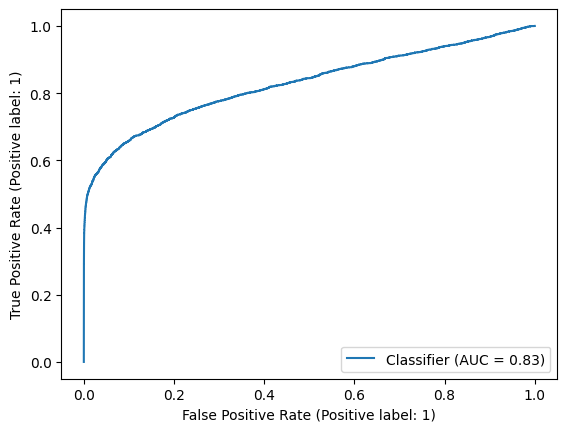

In [46]:
_ = RocCurveDisplay.from_predictions(labels, predictions)

**Model Save**

In [47]:
model.save("fraud_detection_model.keras")

In [48]:
loaded_model = keras.saving.load_model("fraud_detection_model.keras")

# Generate predictions with the loaded model on 5 test examples.
loaded_model.predict(test_ds.rebatch(5).take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


array([[0.12136816],
       [0.07725452],
       [0.2763909 ],
       [0.07164078],
       [0.09354623]], dtype=float32)